In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import ternary
import scipy
import scipy.stats
%matplotlib inline

# Shorten Dirichlet definitions
dirrand = scipy.random.dirichlet
dirpdf = scipy.stats.dirichlet.pdf
dirlogpdf = scipy.stats.dirichlet.logpdf

In [2]:
corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

def draw_pdf_contours(alphas, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dirpdf(xy2bc(xy)/sum(xy2bc(xy)), alphas) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

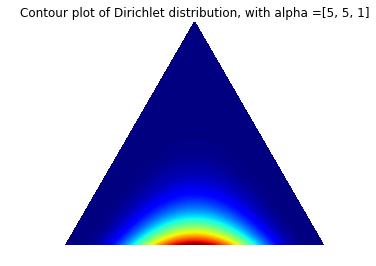

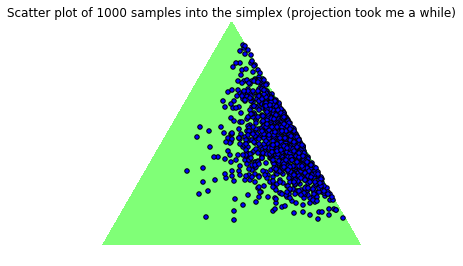

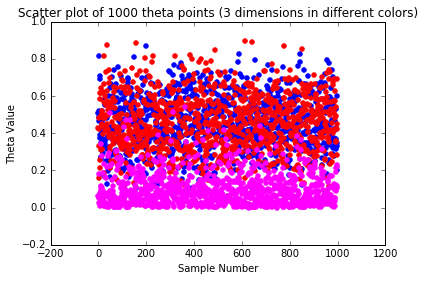

In [3]:
alphas = [5,5,1]

# Draw Dirichlet distribution on mesh with finely sampled points
draw_pdf_contours(alphas)
plt.title('Contour plot of Dirichlet distribution, with alpha ='+str(alphas))

# Scatter plot drawn from samples
plt.figure()
samps = np.random.dirichlet( alphas, size=1000 )
draw_pdf_contours([1,1,1])
plt.scatter( (samps.T[0] + samps.T[1]/2.0), np.sqrt(3)/2*samps.T[1] )
plt.title('Scatter plot of 1000 samples into the simplex (projection took me a while)')

# Scatter sample of points
plt.figure()
plt.scatter(range(samps.shape[0]), samps[:,0],color='blue')
plt.scatter(range(samps.shape[0]), samps[:,1],color='red')
plt.scatter(range(samps.shape[0]), samps[:,2],color='magenta')
plt.xlabel('Sample Number')
plt.ylabel('Theta Value')
plt.title('Scatter plot of 1000 theta points (3 dimensions in different colors)')

<img src="lda-template.png" width="350">
1. $\theta_d | \alpha \sim Dir(\alpha) \in \mathbb{R}^k$
Step 1, Generate thetas for each individual doc

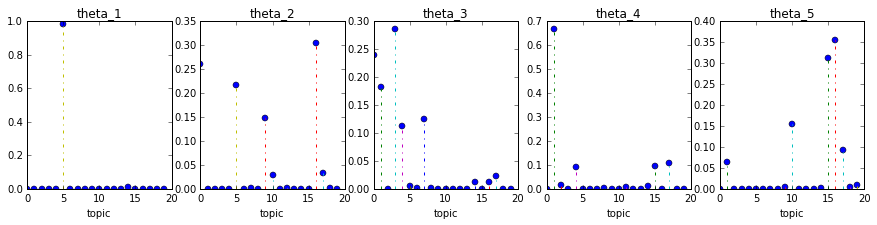

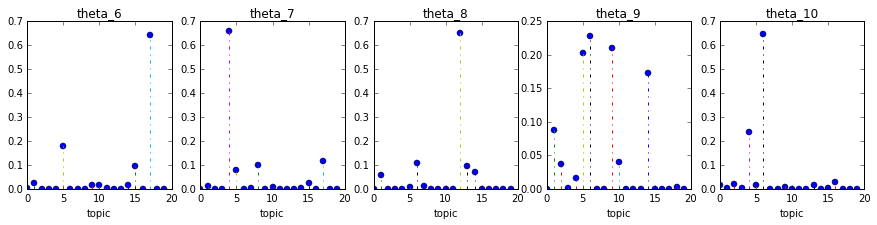

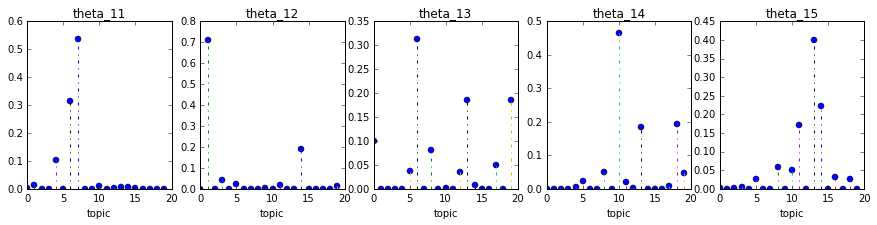

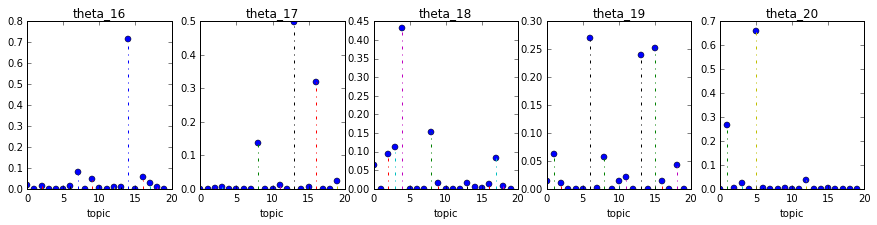

In [4]:
alphas = [0.1]*20
data = dirrand(alphas, 100)
for j in xrange(4):
    plt.figure()
    plt.subplots(1,5,sharey=True,figsize=(15, 3))
    for i in xrange(5):
        plt.subplot(1,5,i+1)
        markerline, stemlines, baseline = plt.stem(range(len(data[j*5+i])),data[j*5+i], '-.')
        plt.xlabel('topic')
        plt.title('theta_'+str(i+j*5+1))

<img src="lda-template.png" width="350">
1. $\theta_d | \alpha \sim Dir(\alpha) \in \mathbb{R}^k$
2. $z_n | \theta \sim Multi(\theta) \in \mathbb{R}^k$

Now, let's sample from theta a whole bunch of z's

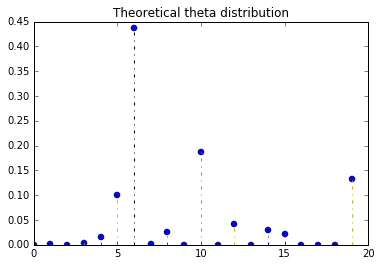

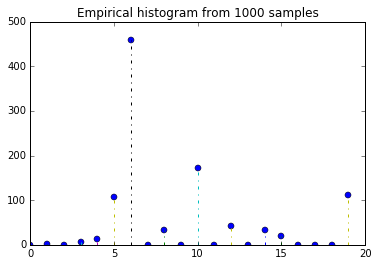

In [93]:
# Define the Dirichlet random variable
alphas = [0.1]*20
# Make a theta from the alpha generated
thetas = dirrand(alphas)
plt.stem(range(len(thetas)),thetas, '-.')
plt.title('Theoretical theta distribution')
# From the topic distribution, generate 100 z's classes
z_n = np.random.multinomial(1000, thetas)
plt.figure()
plt.stem(range(len(z_n)), z_n, '-.')
plt.title('Empirical histogram from 1000 samples')

<img src="lda-template.png" width="350">
1. $\theta_d | \alpha \sim Dir(\alpha) \in \mathbb{R}^k$
2. $z_n | \theta \sim Multi(\theta) \in \mathbb{R}^k$
3. $w_n | z_n, \beta \sim Multi( \beta^T z_n ) \in \mathbb{R}^V$

Now, let's simulate the full plate model, with likelihoods specified by (1-3)

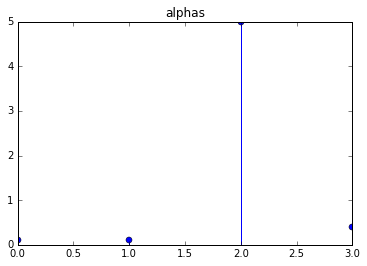

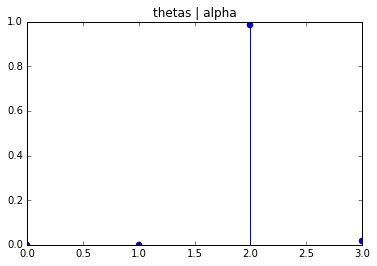

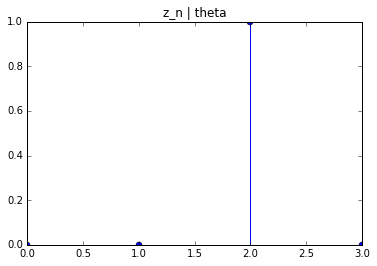

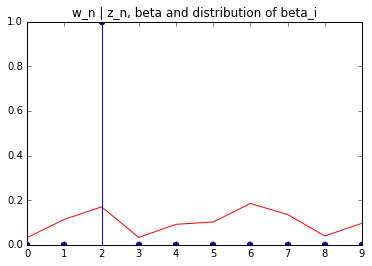

In [92]:
k = 4
V = 10

# Here's an initial set of alphas
alphas = np.array( [0.1]*2 + [5] + [0.4] )

# Draw the distribution of topics
thetas = dirrand(alphas)

# Draw a topic z given the distribution of classes, theta
z_n = np.random.multinomial(1,thetas)

# Beta matrix; each row is a probability distribution for each word given a topic
betas = np.random.rand(V,k)
betas /= betas.sum(axis=0)

# Word that is chosen
w_n = np.random.multinomial(1, betas.dot(z_n))

plt.stem(alphas)
plt.title('alphas')

plt.figure()
plt.stem(thetas)
plt.title('thetas | alpha')

plt.figure()
plt.stem(z_n)
plt.title('z_n | theta')


plt.figure()
plt.plot(betas.dot(z_n),'r')
plt.stem(w_n)
plt.title('w_n | z_n, beta and distribution of beta_i')

The only thing observable are the word counts, which entirely describe what topics are chosen. As it turns out, the posterior probability of $\theta$ by "conjugacy" is also a Dirichlet, though. And that distribution is given by:

$P(\theta | z_n, \alpha) = Dir(\alpha + n(z_{1:N})$)

Here, $n(z_{1:N})$ is the count of the words for each individual topic. As we start to know and learn more and more about the data, the Dirichlet gets peakier and peakier.